In [1]:
import json
import os

from datasets import load_dataset
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
hf_dataset=load_dataset("visual_genome", "relationships_v1.2.0",cache_dir='/data2/zkn/.cache/huggingface/datasets')
# print(hf_dataset)
# print(hf_dataset['train'][0])

/data1/zkn/anaconda3/envs/minigptv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the module from /data2/zkn/.cache/huggingface/modules/datasets_modules/datasets/visual_genome/6a4c7ae0afc696f22ba83bf725357bff6d74714cf3d24d4f07f5aed78d56b626 (last modified on Sun May 19 04:39:13 2024) since it couldn't be found locally at visual_genome, or remotely on the Hugging Face Hub.


In [8]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'url', 'width', 'height', 'coco_id', 'flickr_id', 'relationships'],
        num_rows: 108077
    })
})

In [13]:
shuffled_data=hf_dataset['train'].shuffle(seed=42)
shuffled_data={'train':shuffled_data}

## 关系可视化

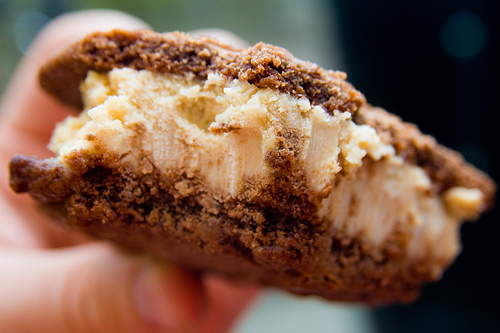

In [21]:
display(shuffled_data['train'][20210]['image'])

In [2]:
from datasets import load_dataset
import datasets
print(datasets.config.HF_DATASETS_CACHE)

/data2/zkn/.cache/huggingface/datasets


In [10]:
from pprint import pprint
from IPython.display import Image
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,FancyArrowPatch
import random
def get_path(image_id):
    Image_path1 = '/data2/zkn/neok_code/Datasets/visual_genome/VG_100K/'
    Image_path2 = '/data2/zkn/neok_code/Datasets/visual_genome/VG_100K_2/'
    # if image is not None:
    image_id = str(image_id)
    if image_id.endswith('.jpg'):
        image_id = image_id.split('.')[0]
    if os.path.exists(os.path.join(Image_path1, image_id+'.jpg')):
        # print('Find image in VG100K(small one!) image path is:',os.path.join(Image_path1, image_id+'.jpg'))
        return os.path.join(Image_path1, image_id+'.jpg')
    elif os.path.exists(os.path.join(Image_path2, image_id+'.jpg')):
        return os.path.join(Image_path2, image_id+'.jpg')
    else:
        print('Cannot find image {}.jpg'.format(image_id))
        return None

def random_color():
    return (random.random(), random.random(), random.random())
def visualize_regions(index, hf_dataset,region_show='true',subject_show='true',object_show='true'):
    image_path=get_path(hf_dataset['train'][index]['image_id'])
    img = PIL_Image.open(image_path)
    plt.imshow(img)
    ax = plt.gca()
    relations=hf_dataset['train'][index]['relationships']
    Rel_num=len(relations)
    dd_num = 0
    for regionA in relations:
        region=regionA['subject']
        subject_x=region['x']
        subject_y=region['y']
        subject_center = (region['x'] + region['w'] / 2, region['y'] + region['h'] / 2)
        
        if subject_show:#subject 矩形框是绿色 文字是黑色
            ax.add_patch(Rectangle((region['x'], region['y']),
                                region['w'],
                                region['h'],
                                fill=False,
                                edgecolor='green',
                                linewidth=1))#subject 矩形框
            
            ax.text(region['x']-5, region['y'], region['names'][0], style='italic', fontsize=10,ha='left', bbox=dict(facecolor='none', edgecolor='none'))#subject 文字
        region=regionA['object']
        object_x=region['x']
        object_y=region['y']
        object_center = (region['x'] + region['w'] / 2, region['y'] + region['h'] / 2)
        if object_show:#object 矩形框是蓝色 文字是蓝色
            ax.add_patch(Rectangle((region['x'], region['y']),
                                region['w'],
                                region['h'],
                                fill=False,
                                edgecolor='blue',
                                linewidth=1))#object 矩形框
            ax.text(region['x']+region['w']+5, region['y']+20, region['names'][0], color='blue',style='italic', fontsize=10,ha='right', bbox=dict(facecolor='none', edgecolor='none'))#object 文字
        
        midpoint_x = (subject_x + object_x) / 2
        midpoint_y = (subject_y + object_y) / 2
        
        
        x_min = min(subject_x, object_x)
        y_min = min(subject_y, object_y)
        x_max = max(subject_x + regionA['subject']['w'], object_x + regionA['object']['w'])
        y_max = max(subject_y + regionA['subject']['h'], object_y + regionA['object']['h'])
        
        width = x_max - x_min
        height = y_max - y_min
        if region_show:#三元组框是粉色 箭头颜色随机 字体是框内白色
            ax.add_patch(Rectangle((x_min, y_min), width, height, fill=False, edgecolor='pink', linewidth=3))#三元组矩形框
            ax.add_patch(FancyArrowPatch(subject_center, object_center, color=random_color(), arrowstyle='->', linewidth=2))#箭头

            phrase=regionA['subject']['names'][0]+' '+regionA['predicate'].lower()+' '+regionA['object']['names'][0]
            ax.text(subject_x, subject_y, phrase, color='black',fontsize=8,style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':5})#白框字体
        dd_num += 1
        if dd_num == 5:
            break
        
    fig = plt.gcf()
    # plt.tick_params(labelbottom='off', labelleft='off')
    plt.axis('off')
    plt.show()

def show_phrase(index,hf_dataset):
    # visualize_regions(index,hf_dataset)
    # pprint(hf_dataset['train'][0].keys())
    image_path=get_path(hf_dataset['train'][index]['image_id'])
    img = PIL_Image.open(image_path)
    plt.axis('off')
    plt.imshow(img)
    # image = Image(filename=image_path)
    
    # display(image)
    relations=hf_dataset['train'][index]['relationships']
    print('There are {} relations in this image'.format(len(relations)))
    rela=[]
    question=[]
    for i in range(len(relations)):
        if relations[i]['predicate'].lower() not in per_list:
            continue
        phrase=relations[i]['subject']['names'][0]+' | '+relations[i]['predicate'].lower()+' | '+relations[i]['object']['names'][0]
        relation_synset = relations[i]['synsets'][2:-1].split('.')[0].lower() # #2:-1 means remove [ and '   original str value is "['along.r.01']"" 
        syn_phrase = relations[i]['subject']['names'][0]+' -->'+ relation_synset +'--> '+relations[i]['object']['names'][0]
        # a={'subject':relations[i]['subject']['names'][0],'predicate':relations[i]['predicate'].lower(),'object':relations[i]['object']['names'][0]}
        rela.append(phrase)
        # rela.append(syn_phrase)
        # pprint(phrase)
        
        if relations[i]['subject']['names'][0].endswith('s'):
            question.append(' Are '+relations[i]['subject']['names'][0] +' '+ relations[i]['predicate'].lower() + ' '+relations[i]['object']['names'][0] +' in this image ?')
        else:
            question.append(' Is there a '+relations[i]['subject']['names'][0] +' ' + relations[i]['predicate'].lower() +' '+relations[i]['object']['names'][0] +' in this image ?')
    return set(rela), set(question)
    


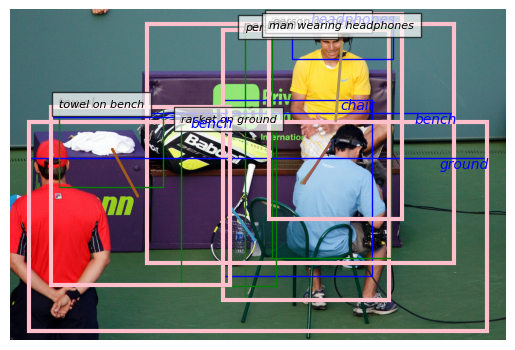

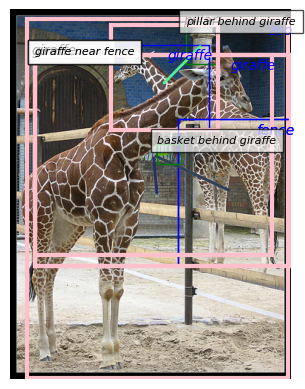

In [17]:
index=7289

# visualize_regions(index,hf_dataset)
visualize_regions(index, hf_dataset,region_show=1,subject_show=1,object_show=1)
# phrase,question = show_phrase(index,hf_dataset)
# pprint(phrase)
# pprint(question)

shuffled_data={'train':shuffled_data}
visualize_regions(index, shuffled_data,region_show=1,subject_show=1,object_show=1)


In [ ]:
VrR_VG=json.load(open('/data2/zkn/neok_code/MiniGPT-4/VrR-VG-all.json'))
print(VrR_VG[0])

In [1]:
import json
rel_num=json.load(open('/data2/zkn/neok_code/MiniGPT-4/hebing.json'))

sorted_rel = dict(sorted(rel_num.items(), key=lambda item: item[1],reverse=True))

# print(sorted_rel)
# with open('sorted.json', 'w') as json_file:
#     json.dump(sorted_rel, json_file, indent=4)

In [2]:
len(sorted_rel)

36550

In [11]:
from pprint import pprint
# pprint(sorted_rel)
sorted_rel['on']
c={}
for k,v in sorted_rel.items():
    len_k=len(k.split(' '))
    if len_k==1:
        # c.append({k:v})
        c[k]=v
        # print(k,v)
print(c)

{'on': 667990, 'has': 245977, 'in': 225353, 'of': 129214, 'wearing': 124834, 'with': 63608, 'behind': 39961, 'holding': 37483, 'near': 26445, 'under': 18459, 'by': 15909, 'wears': 14959, 'above': 13844, 'at': 9154, 'over': 8973, 'for': 8673, 'around': 7638, 'beside': 7571, 'riding': 7551, 'inside': 6502, 'have': 5360, 'carrying': 4630, 'holds': 4446, 'eating': 4436, 'covering': 3693, 'playing': 3677, 'along': 3499, 'between': 3387, 'below': 3371, 'and': 3313, 'watching': 3290, 'against': 2998, 'from': 2785, 'to': 2342, 'says': 2241, 'across': 1950, 'using': 1731, 'outside': 1601, 'crossing': 1594, 'underneath': 1509, 'flying': 1374, 'beneath': 1356, 'swinging': 1302, 'pulling': 1144, 'touching': 1102, 'adorning': 1076, 'a': 1059, 'hitting': 1030, 'supporting': 1002, 'standing': 954, 'next': 943, 'contains': 885, 'walking': 855, 'surrounding': 815, 'cutting': 793, 'throwing': 776, 'sitting': 764, 'lining': 752, 'through': 747, 'covered': 735, 'shows': 731, 'facing': 712, 'front': 691, '

In [12]:
# len(c)
c['with']


63608

In [56]:
per_list=['next','wearing' ,'through', 'containing', 'covers', 'beyond', 'without', 'side', 'among', 
           'besides', 'following', 'past', 'up', 'about', 'alongside', 'behind', 'below', 
           'between', 'down', 'in', 'into', 'near', 'on', 'onto', 'out', 'over', 'round', 
           'under', 'upon', 'with', 'within', 'off', 'towards', 'away', 'between', 'around', 
           'toward', 'inside', 'along', 'across', 'at', 'before', 'behind', 'by', 'down', 
           'for', 'from', 'in', 'near', 'of', 'over', 'since', 'through', 'until', 'up', 'upon']

In [8]:
total=0
for a in sorted_rel:
    total+=sorted_rel[a]
print(total)

2316104


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
values = list(sorted_rel.values())

# 使用对数刻度生成区间
bins = np.logspace(0, np.log10(max(values)), num=10)
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# 计算每个区间的数量
counts, _ = np.histogram(values, bins=bins)

# 创建柱状图
plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('区间')
plt.ylabel('关系的数量')
plt.title('不同值分布下的关系统计')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 显示图表
plt.tight_layout()
plt.show()

## 关系处理

In [ ]:
from pprint import pprint
pprint(hf_dataset['train'][120])

In [10]:
import json
relation_synstes=json.load(open('relationship_synsets.json'))
print(len(relation_synstes))



13536


In [ ]:
synste_list=[]
for k,v in relation_synstes.items():
    print(f'{k} ::   {v}')
    synste_list.append(v)
longggest=max(synste_list,key=len)
print(longggest)


## 制作选择题

In [65]:
len(per_list)
dic_per_list={i:0 for i in per_list}

In [ ]:
dic_per_list

In [ ]:
# 已经获取列表叫per_listfrom
import random
from IPython.display import Image
from tqdm import tqdm
from pprint import pprint
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,FancyArrowPatch
import random
def get_path(image_id):
    Image_path1 = '/data2/zkn/neok_code/Datasets/visual_genome/VG_100K/'
    Image_path2 = '/data2/zkn/neok_code/Datasets/visual_genome/VG_100K_2/'
    # if image is not None:
    image_id = str(image_id)
    if image_id.endswith('.jpg'):
        image_id = image_id.split('.')[0]
    if os.path.exists(os.path.join(Image_path1, image_id+'.jpg')):
        # print('Find image in VG100K(small one!) image path is:',os.path.join(Image_path1, image_id+'.jpg'))
        return os.path.join(Image_path1, image_id+'.jpg')
    elif os.path.exists(os.path.join(Image_path2, image_id+'.jpg')):
        return os.path.join(Image_path2, image_id+'.jpg')
    else:
        print('Cannot find image {}.jpg'.format(image_id))
        return None
per_list=['next','wearing' ,'through', 'containing', 'covers', 'beyond', 'without', 'among', 
           'besides', 'following', 'past', 'up', 'about', 'alongside', 'behind', 'below', 
           'between', 'down', 'in', 'into', 'near', 'on', 'onto', 'out', 'over', 'round', 
           'under', 'upon', 'with', 'within', 'off', 'towards', 'away', 'between', 'around', 
           'toward', 'inside', 'along', 'across', 'at', 'before', 'behind', 'by', 'down', 
           'for', 'from', 'in', 'near', 'of', 'over', 'since', 'through', 'until', 'up', 'upon']
dic_per_list={i:0 for i in per_list}

def filter_phrase(index,hf_dataset,relation_list):

    # image_path=get_path(hf_dataset['train'][index]['image_id'])
    # img = PIL_Image.open(image_path)
    # plt.axis('off')
    # plt.imshow(img)
    relations=hf_dataset['train'][index]['relationships']
    # print('There are {} relations in this image'.format(len(relations)))
    rela=[]
    question=[]
    predicate_list=[]
    for i in range(len(relations)):
        if relations[i]['predicate'].lower() not in relation_list or relations[i]['predicate'].lower() in predicate_list:
            continue
        phrase=relations[i]['subject']['names'][0]+' | '+relations[i]['predicate'].lower()+' | '+relations[i]['object']['names'][0]
        relation_synset = relations[i]['synsets'][2:-1].split('.')[0].lower() 
        # #2:-1 means remove [ and '   original str value is "['along.r.01']"" 
        syn_phrase = relations[i]['subject']['names'][0]+' -->'+ relation_synset +'--> '+relations[i]['object']['names'][0]
        rela.append(phrase)
        # rela.append(syn_phrase)
        
        if relations[i]['subject']['names'][0].endswith('s'):
            question_str= ' Are '+relations[i]['subject']['names'][0] +' '+ relations[i]['predicate'].lower() + ' '+relations[i]['object']['names'][0] +' in this image?'
        else:
            
            question_str=' Is there a '+relations[i]['subject']['names'][0] +' ' + relations[i]['predicate'].lower() +' '+relations[i]['object']['names'][0] +' in this image?'
        question.append({'question':question_str,'relation':relations[i]['predicate'].lower(),'image_id':hf_dataset['train'][index]['image_id']})
        
        predicate_list.append(relations[i]['predicate'].lower())
    
    return set(rela), question



shuffled_data=hf_dataset['train'].shuffle(seed=42)
shuffled_data={'train':shuffled_data}

def get_per_list(hf_dataset,per_list,dic_per_list,requeire_num=1000,):
    judge_list=[]
    for i in tqdm(range(len(hf_dataset['train']))):
        phrase,questions = filter_phrase(i,hf_dataset,per_list)
        if len(phrase)==0:
            continue
        indexa=random.randint(0,len(questions)-1)  #随机选择一个关系词
        relation_word=questions[indexa]['relation']
        if dic_per_list[relation_word]<=20:
            judge_list.append(questions[indexa])  #符合条件的话就加入
            # print(questions[indexa])
            dic_per_list[relation_word]+=1
            if dic_per_list[relation_word]==20:
                print(f'{relation_word} is enough')
                
                per_list.pop(per_list.index(relation_word))#足够的话就pop掉
                print(f'length of judge_list is {len(judge_list)}   dic={len(per_list)}')
            if len(judge_list)==requeire_num:
                break
            
    return judge_list
        

In [6]:
with open('judge_list_841.jsonl', 'w') as json_file:
    json.dump(judge_list, json_file, indent=4)

In [7]:
with open('judge_list.jsonl', 'w', encoding='utf-8') as f:
    for item in judge_list:
        json_line = json.dumps(item)
        f.write(json_line + '\n')

In [5]:
len(judge_list)
print(judge_list[0])

[{'question': ' Is there a shade on street in this image ?', 'relation': 'on', 'image_id': 1}, {'question': ' Is there a parking meter behind man in this image ?', 'relation': 'behind', 'image_id': 1}, {'question': ' Is there a man wearing shirt in this image ?', 'relation': 'wearing', 'image_id': 1}, {'question': ' Are bikes near tree in this image ?', 'relation': 'near', 'image_id': 1}, {'question': ' Is there a lamp post along road in this image ?', 'relation': 'along', 'image_id': 1}, {'question': ' Is there a man in shirt in this image ?', 'relation': 'in', 'image_id': 1}, {'question': ' Are trees by sidewalk in this image ?', 'relation': 'by', 'image_id': 1}, {'question': ' Is there a building with windows in this image ?', 'relation': 'with', 'image_id': 1}]
